Playing around with some stuff

In [84]:
import obspy
import numpy as np
from obspy.clients.fdsn.client import Client
#import cartopy TODO Can't install cartopy
import pandas as pd
import geopandas as gpd
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.linear_model import linear_model

ImportError: cannot import name 'linear_model' from 'sklearn.linear_model' (/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/__init__.py)

In [2]:
# Make an obspy Catalog object from the QuakeML file.
cat = obspy.core.event.read_events('XO_2019_01.quakeml')

In [25]:
event = cat[7]
arrivals = event.origins[0].arrivals
p_arr = [a for a in arrivals if a.phase=='P']
s_arr = [a for a in arrivals if a.phase=='S']
p_dist = [a.distance * 111 for a in p_arr]
s_dist = [s.distance * 111 for s in s_arr]
p_pick = [p for p in event.picks if p.resource_id in [a.pick_id for a in p_arr]]
s_pick = [p for p in event.picks if p.resource_id in [a.pick_id for a in s_arr]]
p_tt = [p.time - event.origins[0].time for p in p_pick]
s_tt = [s.time - event.origins[0].time for s in s_pick]
p_az = [p.azimuth for p in p_arr]
s_az = [s.azimuth for s in s_arr]
#Maleen's code

In [55]:
cat[7].picks[2]

Pick
	     resource_id: ResourceIdentifier(id="quakeml:earthquake.alaska.edu/pick/1574")
	            time: UTCDateTime(2019, 1, 2, 6, 50, 17, 575000)
	     waveform_id: WaveformStreamID(network_code='TA', station_code='I17K', channel_code='BHZ', location_code='--')
	 evaluation_mode: 'automatic'
	   creation_info: CreationInfo(agency_id='AK', author='Alaska Earthquake Center, UAF/GI', creation_time=UTCDateTime(2019, 1, 2, 6, 51, 5, 319000))

In [72]:
cat[7].origins[0].time

2019-01-02T06:48:43.723000Z

In [88]:
def quakeMLReader(event):
    epicenter = (event.origins[0].latitude, event.origins[0].longitude)
    magnitude = event.magnitudes[0].mag
    birthday = event.origins[0].time
    results = []
    for arrival in event.origins[0].arrivals:
        phase = arrival.phase
        azi = arrival.azimuth
        dist = arrival.distance * 111 #there is a note in Maleen's code about this being in degrees
        pick_id = arrival.pick_id
        result = [phase, azi, dist, pick_id]
        results.append(result)
    arrivals = pd.DataFrame(results)
    arrivals.columns = ['phase','azimuth','distance','pick_id']
    results = []
    for pick in event.picks:
        pick_id = pick.resource_id
        time = pick.time
        network_code = pick.waveform_id.network_code
        station_code = pick.waveform_id.station_code
        result = [pick_id, time, network_code, station_code]
        results.append(result)
    picks = pd.DataFrame(results)
    picks.columns = (['pick_id','time','network_code','station_code'])
    picks['travel_time'] = picks['time'] - birthday
    return arrivals.merge(picks, left_on='pick_id', right_on='pick_id').sort_values(by='travel_time')
log = quakeMLReader(cat[7])
log

phase  azimuth  distance                                  pick_id  \
120     P   194.20    53.946  quakeml:earthquake.alaska.edu/pick/1263   
121     P    56.89    54.612  quakeml:earthquake.alaska.edu/pick/1264   
122     P   149.69    61.827  quakeml:earthquake.alaska.edu/pick/1265   
123     P   337.99    70.152  quakeml:earthquake.alaska.edu/pick/1266   
124     P   150.14    71.595  quakeml:earthquake.alaska.edu/pick/1267   
..    ...      ...       ...                                      ...   
114     P     3.00  1088.910  quakeml:earthquake.alaska.edu/pick/1686   
115     P    82.37  1092.795  quakeml:earthquake.alaska.edu/pick/1687   
116     P    87.11  1098.234  quakeml:earthquake.alaska.edu/pick/1688   
117     P    10.19  1104.672  quakeml:earthquake.alaska.edu/pick/1689   
118     S   240.71   662.448  quakeml:earthquake.alaska.edu/pick/1690   

                            time network_code station_code travel_time  
120  2019-01-02T06:48:54.890000Z           XO         KD05      11.167  
121  2019-01-02T06:48:55.078000Z           AV         Q20K      11.355  
122  2019-01-02T06:48:55.960000Z           XO         KD02      12.237  
123  2019-01-02T06:48:56.699000Z           AK         Q19K      12.976  
124  2019-01-02T06:48:56.768000Z           II         KDAK      13.045  
..                           ...          ...          ...         ...  
114  2019-01-02T06:51:00.811000Z           AK         E22K     137.088  
115  2019-01-02T06:51:01.197000Z           AK          JIS     137.474  
116  2019-01-02T06:51:01.451000Z           AK         S32K     137.728  
117  2019-01-02T06:51:01.894000Z           AK         E24K     138.171  
118  2019-01-02T06:51:14.148000Z           XO         WS28     150.425  

[428 rows x 8 columns]

P-wave slope is 8.167426703737915 km/s.
S-wave slope is 4.825493373364722 km/s.


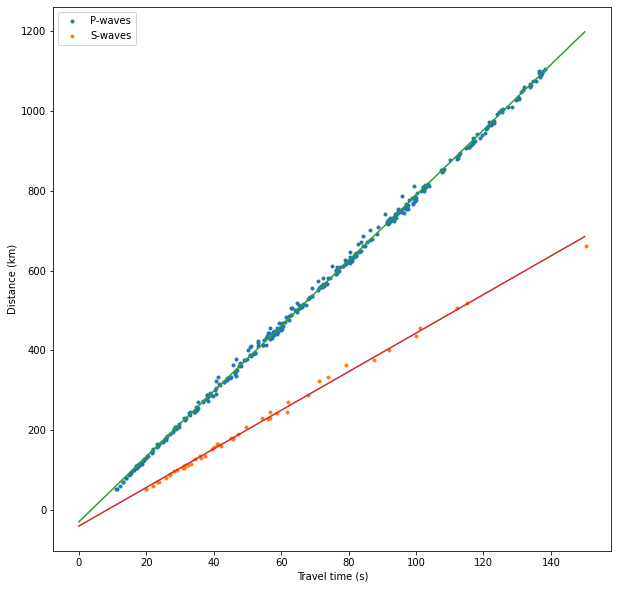

In [89]:
#replicating Maleen's plot
p_log = log[log['phase'] == 'P']
s_log = log[log['phase'] == 'S']

fig,ax = plt.subplots(1,1,figsize=[10,10])
ax.plot(p_log['travel_time'],p_log['distance'],'.')
ax.plot(s_log['travel_time'],s_log['distance'],'.')
ax.set_xlabel('Travel time (s)')
ax.set_ylabel('Distance (km)')
ax.legend(['P-waves','S-waves'])

np.polyfit(p_log['travel_time'].tolist(),p_log['distance'].tolist(),1)

# P-wave fit
m,b = np.polyfit(p_log['travel_time'].tolist(),p_log['distance'].tolist(),1)
x_p = np.linspace(0,150)
ax.plot(x_p,x_p*m + b,'-')
print('P-wave slope is '+str(m)+' km/s.')

# S-wave fit
m,b = np.polyfit(s_log['travel_time'].tolist(),s_log['distance'].tolist(),1)
x_p = np.linspace(0,150)
ax.plot(x_p,x_p*m + b,'-')
print('S-wave slope is '+str(m)+' km/s.')